In [1]:
# IMPORTS LIBRARIES

import datetime
import os
import pathlib

import numpy as np
import rasterio
import torch
from matplotlib import pyplot as plt
from satellite_data_product.sentinel2_legacy.stages.sim_creation.sim_creation_utils import (
    get_gamma,
    sim_radtran,
)

from src.azure_wrap.ml_client_utils import initialize_blob_service_client
from src.data.atmospheric_data import ATMOSPHERIC_DATA
from src.data.recycled_plumes.data_item import OldMultiTemporalPlumesDataItem
from src.data.sentinel2 import SceneClassificationLabel as SCLabel
from src.inference.inference_functions import (
    obtain_data_items_4by4,
    predict,
)
from src.inference.inference_target_location import add_retrieval_to_pred, plot_prediction
from src.plotting.plotting_functions import plot_frac
from src.training.loss_functions import TwoPartLoss
from src.utils.parameters import MAIN_IDX
from src.utils.utils import initialize_clients, load_model_and_concatenator

In [2]:
# DEFINE GLOBAL VARIABLES

SC_MASK_LABELS = [
    SCLabel.NO_DATA,
    SCLabel.CLOUD_HIGH_PROBABILITY,
    SCLabel.CLOUD_MEDIUM_PROBABILITY,
]
S2_BANDS = [
    "B01",
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B09",
    "B11",
    "B12",
    "B8A",
    "SCL",
]

CROP_SIZE = 128
AVOGADRO_CONSTANT = 6.02214076e23
SIM_SPACING_RESOLUTION = 5000

# Initialize clients
ml_client, _, _, s3_client = initialize_clients(force_msi=False)
abs_client = initialize_blob_service_client(ml_client)

##### Load Plume Retrieval

In [3]:
# HELPER FUNCTIONS


def apply_methane_absorption(
    methane_free: OldMultiTemporalPlumesDataItem,
    retrieval: np.ndarray,
    instrument,
    gamma,
    plume_file: pathlib.Path,
    bands: list[str],
    swir16_band_name: str,
    swir22_band_name: str,
    modulate_swir16: float = 1.0,
    modulate_swir22: float = 1.0,
) -> OldMultiTemporalPlumesDataItem:
    """
    Take a OldMultiTemporalPlumesDataItem and apply additional absorption in bands 11 and 12 for the concentration of methane specified in `retrieval`.

    This creates a new modified OldMultiTemporalPlumesDataItem.
    """
    index_swir16 = bands.index(swir16_band_name)
    index_swir22 = bands.index(swir22_band_name)

    orig_swir16 = methane_free.orig_swir16
    orig_swir22 = methane_free.orig_swir22

    assert orig_swir16.shape == retrieval.shape
    band_frac_offset = 100.0
    offset_swir16 = orig_swir16 + band_frac_offset
    offset_swir22 = orig_swir22 + band_frac_offset

    # apply radiative transfer
    sim_swir16, _ = sim_radtran(
        s2_ref_band=offset_swir16,
        s2_band=offset_swir22,
        **ATMOSPHERIC_DATA[instrument],
        methane_enhancement=retrieval * modulate_swir16,
        gamma=gamma,
        av_constant=AVOGADRO_CONSTANT,
        spacing_resolution=SIM_SPACING_RESOLUTION,
    )

    _, sim_swir22 = sim_radtran(
        s2_ref_band=offset_swir16,
        s2_band=offset_swir22,
        **ATMOSPHERIC_DATA[instrument],
        methane_enhancement=retrieval * modulate_swir22,
        gamma=gamma,
        av_constant=AVOGADRO_CONSTANT,
        spacing_resolution=SIM_SPACING_RESOLUTION,
    )

    # calculate FRAC from the simulated bands
    band_ratio = offset_swir22 / offset_swir16
    sim_band_ratio = sim_swir22 / sim_swir16
    reference_frac = (sim_band_ratio - band_ratio) / band_ratio
    # now remove the offset from the simulated bands and clip to zero
    # (otherwise we're giving the neural network information
    #  that wouldn't actually be present in a real image)
    np.clip(sim_swir16 - band_frac_offset, a_min=0.0, a_max=None, out=sim_swir16)
    np.clip(sim_swir22 - band_frac_offset, a_min=0.0, a_max=None, out=sim_swir22)
    # and also round to the nearest integer, again
    # so the neural network can't use non-integer values
    # as a way to detect methane
    np.round(sim_swir16, decimals=0, out=sim_swir16)
    np.round(sim_swir22, decimals=0, out=sim_swir22)
    # Modify the main crop array's band 11 and 12
    crop_main = methane_free.crop_main.copy()
    crop_main[index_swir16] = sim_swir16
    crop_main[index_swir22] = sim_swir22

    plume_item = OldMultiTemporalPlumesDataItem(
        crop_earlier=methane_free.crop_earlier,
        crop_before=methane_free.crop_before,
        crop_main=crop_main,
        crop_after=methane_free.crop_after,
        orig_swir16=methane_free.orig_swir16,
        orig_swir22=methane_free.orig_swir22,
        target_frac=1 - (1 - methane_free.target_frac) * (1 - reference_frac.astype(np.float32)),
        mask_earlier=methane_free.mask_earlier,
        mask_before=methane_free.mask_before,
        mask_main=methane_free.mask_main,
        mask_after=methane_free.mask_after,
        granule_item_ids=methane_free.granule_item_ids,
        plume_files=[plume_file],
        bands=methane_free.bands,
        size=methane_free.size,
        crop_x=methane_free.crop_x,
        crop_y=methane_free.crop_y,
        main_cloud_ratio=methane_free.main_cloud_ratio,
    )
    abs_swir16 = sim_swir16 / orig_swir16
    abs_swir22 = sim_swir22 / orig_swir22
    return plume_item, abs_swir16, abs_swir22

In [4]:
# Define plume directories
in_dir = pathlib.Path(os.path.abspath("../test/in/data/recycled_plumes"))
plume_dir = in_dir / "plumes"
plume_files = list(plume_dir.glob("**/*.tiff"))
assert len(plume_files) > 0

# Define target tile properties
lat, lon = 31.896, -104.032
target_date = datetime.datetime(2024, 5, 14, tzinfo=datetime.timezone.utc)

###### Pick and insert random plume for testing

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.06s/it]


Dates of S2 items found:
2024-04-29 17:29:01.024000+00:00
2024-05-09 17:29:01.024000+00:00
2024-05-14 17:28:59.024000+00:00
2024-05-19 17:29:01.024000+00:00
2024-05-24 17:28:59.024000+00:00


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:22<00:00, 11.06s/it]


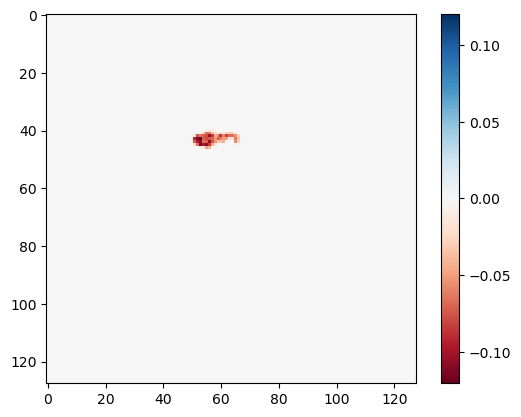

In [5]:
# Step 1: just grab a random plume from the test directory

plume_file = plume_files[0]
with rasterio.open(plume_file) as plume_ds:
    retrieval = plume_ds.read(1)
    retrieval /= 10000

# Step 2: place the plume somewhere inside of the tile-sized 2D array

methane_enhancement_molpercm2 = np.zeros((CROP_SIZE, CROP_SIZE), dtype=float)
x, y = 40, 50
methane_enhancement_molpercm2[x : x + retrieval.shape[0], y : y + retrieval.shape[1]] = np.where(
    retrieval > 0, retrieval, 0.0
)

# Step 3: Load target Sentinel-2 tile
data_item_generator = obtain_data_items_4by4(
    lat,
    lon,
    start_time=target_date - datetime.timedelta(days=15),
    end_time=target_date + datetime.timedelta(days=15),
    crop_size=CROP_SIZE,
    max_cloud_ratio=0.2,
    abs_client=abs_client,
    s3_client=s3_client,
    l1c=False,  # keeping as False since these outputs were generated with L2A
)

data_items = list(data_item_generator)
# the index of the scene nearest the target date
itarget = np.argmin([abs((timestamp - target_date).total_seconds()) for (data_item, timestamp, s2_item) in data_items])
methane_free, timestamp, s2_stack = data_items[itarget]

# Step 4: Add methane to Sentinel-2 tile

instrument = s2_stack[MAIN_IDX].instrument
gamma = get_gamma(s2_stack[MAIN_IDX].solar_angle, s2_stack[MAIN_IDX].observation_angle)
plume_item, _, _ = apply_methane_absorption(
    methane_free, methane_enhancement_molpercm2, instrument, gamma, plume_file, S2_BANDS, "B11", "B12"
)

# Visuaise the tile as a sanity check
plot_frac(torch.Tensor(plume_item.target_frac))
plt.colorbar()

##### Detect methane using CV

In [6]:
# load the model from an experiment
# Note: this sometimes gets stuck, it should only take a few seconds
# If that happens, just interrupt the kernel and run the cell again.
# https://learn.microsoft.com/en-us/azure/machine-learning/how-to-manage-models-mlflow?view=azureml-api-2#loading-models-from-registry

model, band_concatenator, training_params = load_model_and_concatenator("models:/torchgeo_pwr_unet/70", device="cpu")
lossFn = TwoPartLoss(
    binary_threshold=training_params["binary_threshold"], MSE_multiplier=training_params["MSE_multiplier"]
)

2024-09-10 17:51:49 [INFO] Parsing tracking uri /mlflow/v1.0/subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourceGroups/orbio-ml-rg/providers/Microsoft.MachineLearningServices/workspaces/orbio-ml-ml-workspace (utils.py:234)
2024-09-10 17:51:49 [INFO] Tracking uri /mlflow/v1.0/subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourceGroups/orbio-ml-rg/providers/Microsoft.MachineLearningServices/workspaces/orbio-ml-ml-workspace has sub id 6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab, resource group orbio-ml-rg, and workspace orbio-ml-ml-workspace (utils.py:256)
2024-09-10 17:51:49 [INFO] Fetching cloud metadata from known urls (cloud.py:520)
2024-09-10 17:51:49 [INFO] Cloud was fetched from known metadataurls (cloud.py:469)
2024-09-10 17:51:49 [INFO] Cloud metadata not found so falling back to AzureCloud as default (cloud.py:481)
2024-09-10 17:51:49 [INFO] No environment configuration found. (environment.py:115)
2024-09-10 17:51:49 [INFO] ManagedIdentityCredential will use Azure ML mana

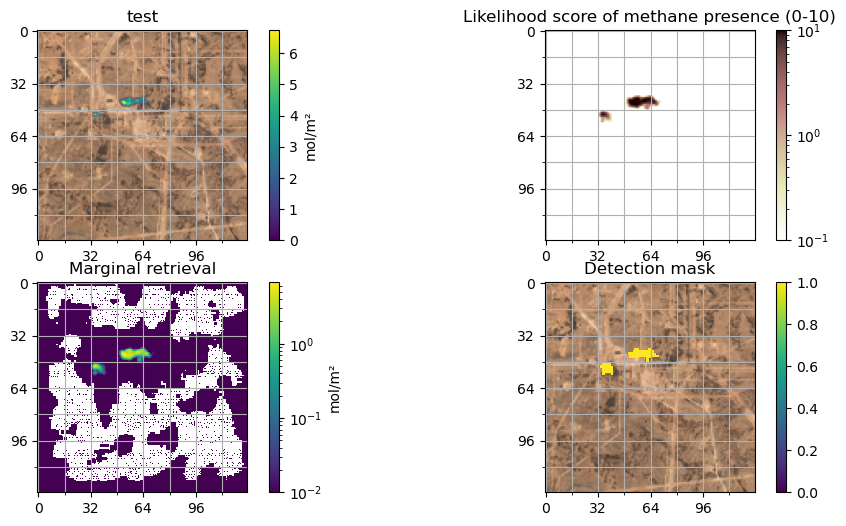

In [7]:
# Visuaise the prediction as a sanity check
pred_dict = predict(
    model=model,
    device="cpu",
    band_concatenator=band_concatenator,
    recycled_item=plume_item,
    lossFn=lossFn,
)  # NOTE: predict stores the 4D arrays for each prediction. We squeeze in the plotting fns where necessary

# NOTE: it seems like plot_prediction requires the retrieval to be added to pred_dict. So we run that fn first
main_s2_item = s2_stack[MAIN_IDX]
pred = add_retrieval_to_pred(pred_dict, main_s2_item)
plt.figure(figsize=(12, 6))
plot_prediction(pred_dict, "test")

#### Modulate B11 and B12 absorption

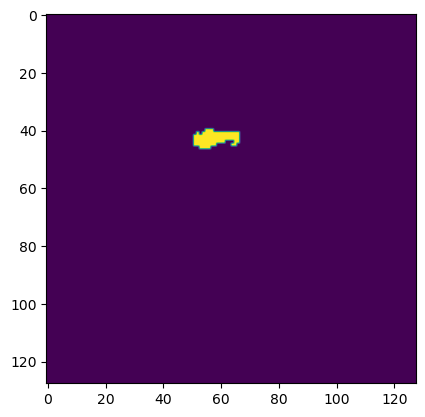

In [8]:
# Define plume mask

ground_truth_mask = methane_enhancement_molpercm2 > 1e-9

plt.imshow(ground_truth_mask)

In [9]:
# Define modulation array

modulate_arr = np.linspace(-2.0, 2.0, 50)
modulate_arr

array([-2.        , -1.91836735, -1.83673469, -1.75510204, -1.67346939,
       -1.59183673, -1.51020408, -1.42857143, -1.34693878, -1.26530612,
       -1.18367347, -1.10204082, -1.02040816, -0.93877551, -0.85714286,
       -0.7755102 , -0.69387755, -0.6122449 , -0.53061224, -0.44897959,
       -0.36734694, -0.28571429, -0.20408163, -0.12244898, -0.04081633,
        0.04081633,  0.12244898,  0.20408163,  0.28571429,  0.36734694,
        0.44897959,  0.53061224,  0.6122449 ,  0.69387755,  0.7755102 ,
        0.85714286,  0.93877551,  1.02040816,  1.10204082,  1.18367347,
        1.26530612,  1.34693878,  1.42857143,  1.51020408,  1.59183673,
        1.67346939,  1.75510204,  1.83673469,  1.91836735,  2.        ])

###### B11

Modulate B11 according to the modulation array. B12 remains untouched and has its the original plume values.

In [10]:
data_items = []
ratio_mean_diff = []
for mod_val in modulate_arr:
    data_item, abs_b11, abs_b12 = apply_methane_absorption(
        methane_free, methane_enhancement_molpercm2, instrument, gamma, plume_file, modulate_b11=(1 + mod_val)
    )
    data_items.append(data_item)

    abs_ratio = (1 - abs_b12) / (1 - abs_b11)
    diff = np.nanmean(abs_ratio[abs_ratio > 0.0])  # reference_plume_abs_ratio - np.nanmean(abs_ratio[abs_ratio>0.0])
    ratio_mean_diff.append(diff)

min_frac = np.array([abs(t.target_frac.min()) for t in data_items])
diff_from_reference_ratio_mean = np.array(ratio_mean_diff)
modulate_pred = np.array([predict(model, "cpu", band_concatenator, mod, lossFn) for mod in data_items])
mean_prob_of_modulate_pred_in_mask = np.array(
    [np.mean(pred["binary_probability"].numpy(), where=ground_truth_mask) for pred in modulate_pred]
)

/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: divide by zero encountered in divide
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)
/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: invalid value encountered in divide
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)
/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: invalid value encountered in cast
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)
/tmp/ipykernel_3383763/2507550601.py:9: RuntimeWarning: divide by zero encountered in divide
  abs_ratio = (1 - abs_b12) / (1 - abs_b11)
/tmp/ipykernel_3383763/2507

Text(0, 0.5, 'Likelihood score over plume mask')

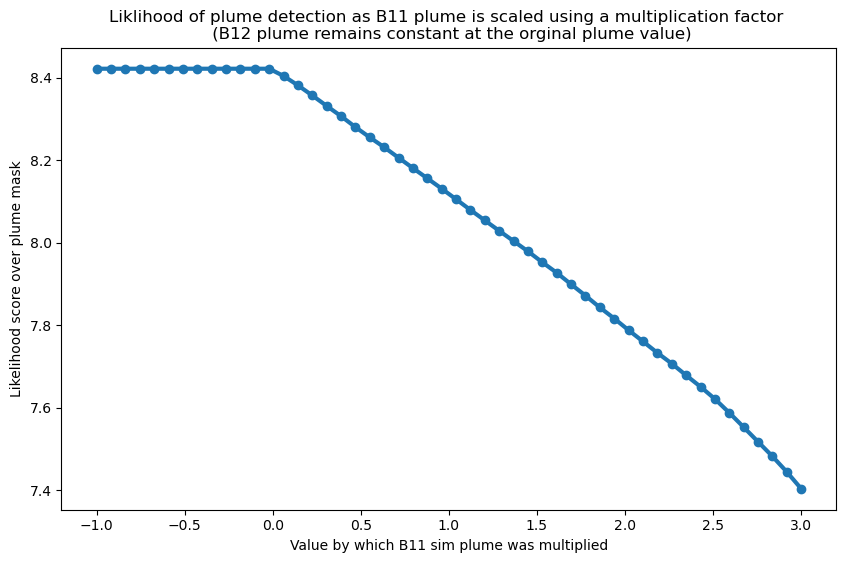

In [11]:
# Plot results

plt.figure(figsize=(10, 6))
plt.plot(modulate_arr + 1, mean_prob_of_modulate_pred_in_mask * 10, "o-", linewidth=3)
plt.title(
    "Liklihood of plume detection as B11 plume is scaled using a multiplication factor \n (B12 plume remains constant at the orginal plume value)"
)
plt.xlabel("Value by which B11 sim plume was multiplied")
plt.ylabel("Likelihood score over plume mask")

###### B12

Modulate B12 according to the modulation array. B11 remains untouched and has its the original plume values.

In [12]:
data_items = []
ratio_mean_diff = []
for mod_val in modulate_arr:
    data_item, abs_b11, abs_b12 = apply_methane_absorption(
        methane_free, methane_enhancement_molpercm2, instrument, gamma, plume_file, modulate_b12=(1 + mod_val)
    )
    data_items.append(data_item)

    abs_ratio = (1 - abs_b12) / (1 - abs_b11)
    diff = np.nanmean(abs_ratio[abs_ratio > 0.0])  # reference_plume_abs_ratio - np.nanmean(abs_ratio[abs_ratio>0.0])
    ratio_mean_diff.append(diff)

min_frac = np.array([abs(t.target_frac.min()) for t in data_items])
diff_from_reference_ratio_mean = np.array(ratio_mean_diff)
modulate_pred = np.array([predict(model, "cpu", band_concatenator, mod, lossFn) for mod in data_items])
mean_prob_of_modulate_pred_in_mask = np.array(
    [np.mean(pred["binary_probability"].numpy(), where=ground_truth_mask) for pred in modulate_pred]
)

/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: divide by zero encountered in divide
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)
/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: invalid value encountered in divide
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)
/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: invalid value encountered in cast
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)
/tmp/ipykernel_3383763/1099832615.py:9: RuntimeWarning: invalid value encountered in divide
  abs_ratio = (1 - abs_b12) / (1 - abs_b11)
/tmp/ipykernel_3383763/10998

Text(0, 0.5, 'Likelihood score over plume mask')

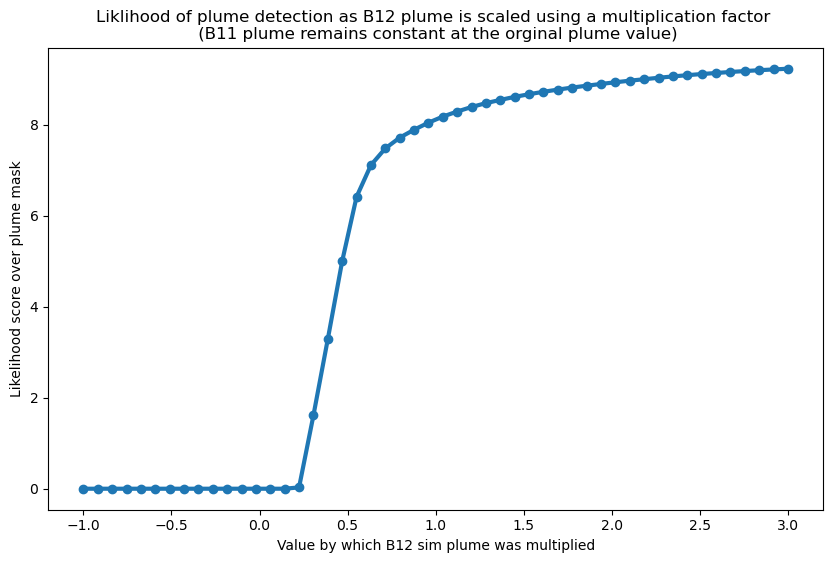

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(modulate_arr + 1, mean_prob_of_modulate_pred_in_mask * 10, "o-", linewidth=3)
plt.title(
    "Liklihood of plume detection as B12 plume is scaled using a multiplication factor \n (B11 plume remains constant at the orginal plume value)"
)
plt.xlabel("Value by which B12 sim plume was multiplied")
plt.ylabel("Likelihood score over plume mask")

###### B11

Modulate B11 according to the modulation array. B12 plume is set to 0.0.

In [14]:
# If B12 is 0.0
data_items = []
ratio_mean_diff = []
for mod_val in modulate_arr:
    data_item, abs_b11, abs_b12 = apply_methane_absorption(
        methane_free,
        methane_enhancement_molpercm2,
        instrument,
        gamma,
        plume_file,
        modulate_b11=(1 + mod_val),
        modulate_b12=0.0,
    )
    data_items.append(data_item)

    abs_ratio = (1 - abs_b12) / (1 - abs_b11)
    diff = np.nanmean(abs_ratio[abs_ratio > 0.0])  # reference_plume_abs_ratio - np.nanmean(abs_ratio[abs_ratio>0.0])
    ratio_mean_diff.append(diff)

min_frac = np.array([abs(t.target_frac.min()) for t in data_items])
diff_from_reference_ratio_mean = np.array(ratio_mean_diff)
modulate_pred = np.array([predict(model, "cpu", band_concatenator, mod, lossFn) for mod in data_items])
mean_prob_of_modulate_pred_in_mask = np.array(
    [np.mean(pred["binary_probability"].numpy(), where=ground_truth_mask) for pred in modulate_pred]
)

/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: divide by zero encountered in divide
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)
/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: invalid value encountered in divide
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)
/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: invalid value encountered in cast
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)
/tmp/ipykernel_3383763/1759390293.py:10: RuntimeWarning: invalid value encountered in divide
  abs_ratio = (1 - abs_b12) / (1 - abs_b11)
/tmp/ipykernel_3383763/1759

Text(0, 0.5, 'Likelihood score over plume mask')

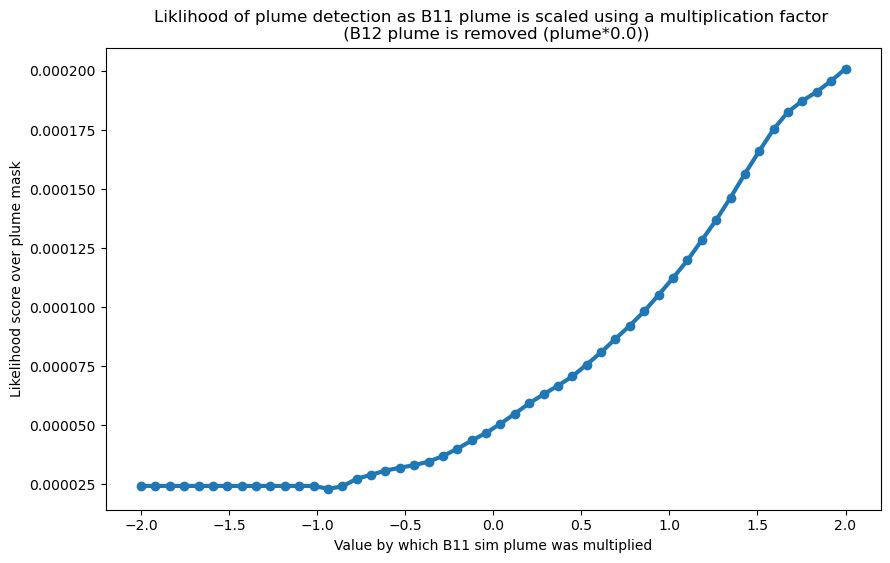

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(modulate_arr, mean_prob_of_modulate_pred_in_mask * 10, "o-", linewidth=3)
plt.title(
    "Liklihood of plume detection as B11 plume is scaled using a multiplication factor \n (B12 plume is removed (plume*0.0))"
)
plt.xlabel("Value by which B11 sim plume was multiplied")
plt.ylabel("Likelihood score over plume mask")

###### B12

Modulate B12 according to the modulation array. B11 plume is set to 0.0.

In [16]:
# If B11 is 0.0
data_items = []
ratio_mean_diff = []
for mod_val in modulate_arr:
    data_item, abs_b11, abs_b12 = apply_methane_absorption(
        methane_free,
        methane_enhancement_molpercm2,
        instrument,
        gamma,
        plume_file,
        modulate_b11=0.0,
        modulate_b12=(1 + mod_val),
    )
    data_items.append(data_item)

    abs_ratio = (1 - abs_b12) / (1 - abs_b11)
    diff = np.nanmean(abs_ratio[abs_ratio > 0.0])  # reference_plume_abs_ratio - np.nanmean(abs_ratio[abs_ratio>0.0])
    ratio_mean_diff.append(diff)

min_frac = np.array([abs(t.target_frac.min()) for t in data_items])
diff_from_reference_ratio_mean = np.array(ratio_mean_diff)
modulate_pred = np.array([predict(model, "cpu", band_concatenator, mod, lossFn) for mod in data_items])
mean_prob_of_modulate_pred_in_mask = np.array(
    [np.mean(pred["binary_probability"].numpy(), where=ground_truth_mask) for pred in modulate_pred]
)

/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: invalid value encountered in divide
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)
/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: invalid value encountered in cast
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)
/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: divide by zero encountered in divide
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)
/tmp/ipykernel_3383763/3620162281.py:10: RuntimeWarning: invalid value encountered in divide
  abs_ratio = (1 - abs_b12) / (1 - abs_b11)
/tmp/ipykernel_3383763/3620

Text(0, 0.5, 'Likelihood score over plume mask')

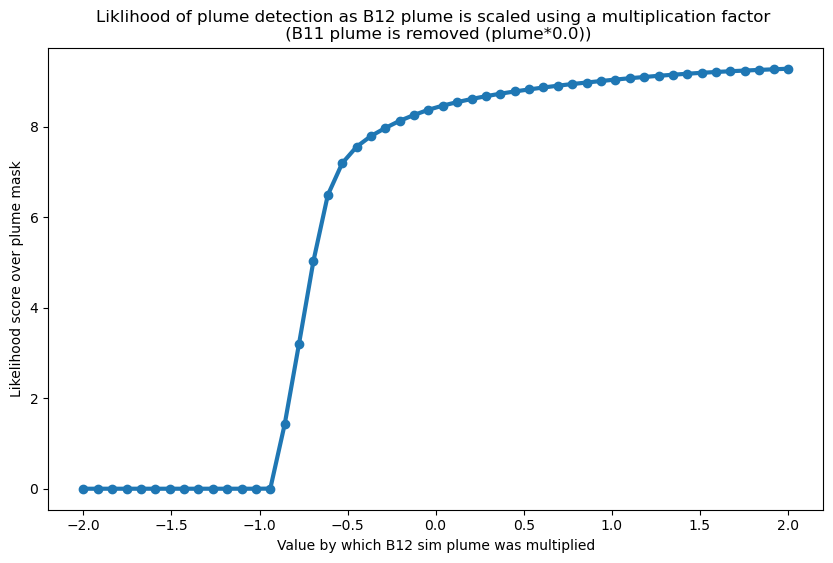

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(modulate_arr, mean_prob_of_modulate_pred_in_mask * 10, "o-", linewidth=3)
plt.title(
    "Liklihood of plume detection as B12 plume is scaled using a multiplication factor \n (B11 plume is removed (plume*0.0))"
)
plt.xlabel("Value by which B12 sim plume was multiplied")
plt.ylabel("Likelihood score over plume mask")

###### B11

Modulate B11 according to the modulation array for 15 randomly selected plumes. B12 plume is set to 0.0.

In [18]:
plume_series = []
cnt = 0
for plume in plume_files:
    if cnt == 10:
        break
    with rasterio.open(plume) as plume_ds:
        ret = plume_ds.read(1)
        # convert from mol/m2 to mol/cm2 (there are 10,000 cm2 in a m2)
        ret /= 10000

    methane_enhancement_molpercm2 = np.zeros((CROP_SIZE, CROP_SIZE), dtype=float)
    x, y = 40, 50
    methane_enhancement_molpercm2[x : x + ret.shape[0], y : y + ret.shape[1]] = np.where(ret > 0, ret, 0.0)

    data_items = []
    for mod_val in modulate_arr:
        data_item, abs_b11, abs_b12 = apply_methane_absorption(
            methane_free,
            methane_enhancement_molpercm2,
            instrument,
            gamma,
            plume,
            modulate_b11=(1 + mod_val),
            modulate_b12=0.0,
        )
        data_items.append(data_item)

    min_frac = np.array([abs(t.target_frac.min()) for t in data_items])
    diff_from_reference_ratio_mean = np.array(ratio_mean_diff)
    modulate_pred = np.array([predict(model, "cpu", band_concatenator, mod, lossFn) for mod in data_items])
    mean_prob_of_modulate_pred_in_mask = np.array(
        [np.mean(pred["binary_probability"].numpy(), where=ground_truth_mask) for pred in modulate_pred]
    )
    plume_series.append(mean_prob_of_modulate_pred_in_mask)
    cnt += 1

/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: divide by zero encountered in divide
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)
/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: invalid value encountered in divide
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)
/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: invalid value encountered in cast
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)


Text(0, 0.5, 'Likelihood score over plume mask')

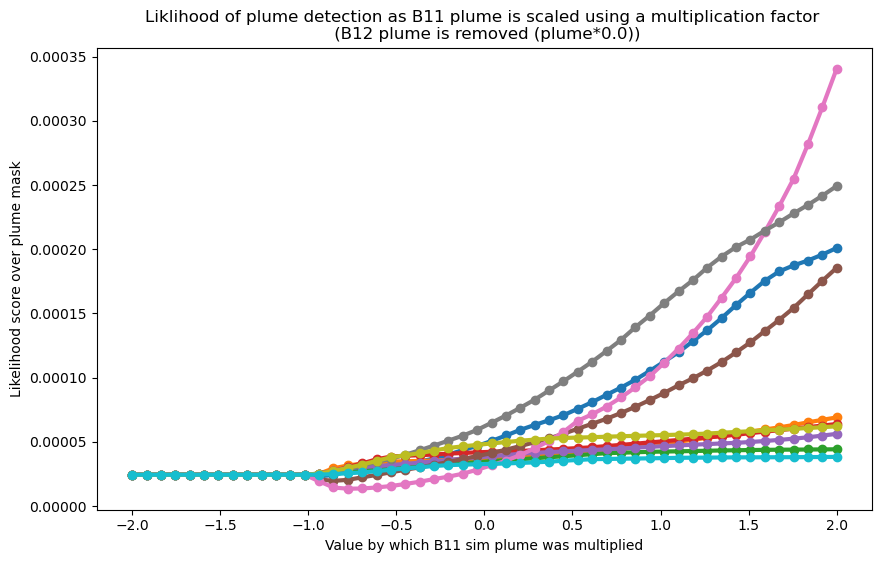

In [19]:
plt.figure(figsize=(10, 6))
for series in plume_series:
    plt.plot(modulate_arr, series * 10, "o-", linewidth=3)
plt.title(
    "Liklihood of plume detection as B11 plume is scaled using a multiplication factor \n (B12 plume is removed (plume*0.0))"
)
plt.xlabel("Value by which B11 sim plume was multiplied")
plt.ylabel("Likelihood score over plume mask")

###### B12

Modulate B12 according to the modulation array for 15 randomly selected plumes. B11 plume is set to 0.0.

In [20]:
plume_series = []
cnt = 0
for plume in plume_files:
    if cnt == 15:
        break
    with rasterio.open(plume) as plume_ds:
        ret = plume_ds.read(1)
        # convert from mol/m2 to mol/cm2 (there are 10,000 cm2 in a m2)
        ret /= 10000

    methane_enhancement_molpercm2 = np.zeros((CROP_SIZE, CROP_SIZE), dtype=float)
    x, y = 40, 50
    methane_enhancement_molpercm2[x : x + ret.shape[0], y : y + ret.shape[1]] = np.where(ret > 0, ret, 0.0)

    data_items = []
    for mod_val in modulate_arr:
        data_item, abs_b11, abs_b12 = apply_methane_absorption(
            methane_free,
            methane_enhancement_molpercm2,
            instrument,
            gamma,
            plume,
            modulate_b11=0.0,
            modulate_b12=(1 + mod_val),
        )
        data_items.append(data_item)

    min_frac = np.array([abs(t.target_frac.min()) for t in data_items])
    diff_from_reference_ratio_mean = np.array(ratio_mean_diff)
    modulate_pred = np.array([predict(model, "cpu", band_concatenator, mod, lossFn) for mod in data_items])
    mean_prob_of_modulate_pred_in_mask = np.array(
        [np.mean(pred["binary_probability"].numpy(), where=ground_truth_mask) for pred in modulate_pred]
    )
    plume_series.append(mean_prob_of_modulate_pred_in_mask)
    cnt += 1

/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: invalid value encountered in divide
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)
/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: invalid value encountered in cast
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)
/home/azureuser/monorepo-new/data_product/satellite_data_product/sentinel2_legacy/stages/sim_creation/sim_creation_utils.py:221: RuntimeWarning: divide by zero encountered in divide
  index = np.floor((methane_enhancement_molpercm2_1d / max_ch4) * spacing_resolution).astype(int)


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 6))
for series in plume_series:
    plt.plot(modulate_arr, series * 10, "o-", linewidth=3)
plt.title(
    "Liklihood of plume detection as B12 plume is scaled using a multiplication factor \n (B11 plume is removed (plume*0.0))"
)
plt.xlabel("Value by which B12 sim plume was multiplied")
plt.ylabel("Likelihood score over plume mask")